## Sale forecasting with Prophet

### Loading the libraries

In [1]:
import datalabframework as dlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pyspark.sql import Window
from pyspark.sql import functions as F

### Loading the fact table and the dataset

In [3]:
dlf.project.load()

SPARK_DIST_CLASSPATH not defined and spark installed without hadoop
define SPARK_DIST_CLASSPATH in $SPARK_HOME/conf/spark-env.sh as follows:

   export SPARK_DIST_CLASSPATH=$(hadoop classpath)

for more info refer to: https://spark.apache.org/docs/latest/hadoop-provided.html

ERROR:dlf:Hadoop is not detected. Some packages/jars might not work correctly.


In [4]:
engine = dlf.project.engine()

In [5]:
df = engine.load("fact_table")

INFO:dlf:{'md': {'hash': '0x87b8a711968940ec', 'url': 'hdfs://bigdata-m.teko.vn:18020/teko/prod/etl/fact/fact_table', 'service': 'hdfs', 'format': 'parquet', 'host': 'bigdata-m.teko.vn', 'port': 18020, 'driver': None, 'database': None, 'username': None, 'password': None, 'resource_path': 'fact_table', 'provider_path': '/teko/prod/etl/fact', 'provider_alias': 'fact', 'resource_alias': 'fact_table', 'cache': None, 'date_column': None, 'date_start': None, 'date_end': None, 'date_window': None, 'date_partition': None, 'update_column': None, 'hash_column': None, 'state_column': None, 'options': {}, 'mapping': {}}, 'mode': None, 'records': 6163437, 'columns': 128, 'time': 12.754551542922854, 'time_core': 6.219377351924777, 'time_prep': 6.5351730063557625}


In [6]:
transactions_df = df.select('transaction_date', 'sku_id', 'sku_name', 'cat_name', 'cat_root_name', 'quantity', 'discount', 'unit_price', 'brand_name') \
.filter((df.doc_type == 'PTX') | (df.doc_type == 'HDF'))

In [7]:
laptop_transactions_df = transactions_df.select('transaction_date', 'quantity') \
.filter(transactions_df.cat_root_name == 'laptop') \
.groupby('transaction_date') \
.agg(F.sum('quantity').alias('daily_quantity')) \
.orderBy('transaction_date').toPandas()

In [8]:
laptop_transactions_df.head(10)

,transaction_date,daily_quantity
0,2017-01-01,86.0000
1,2017-01-02,105.0000
2,2017-01-03,102.0000
3,2017-01-04,113.0000
4,2017-01-05,97.0000
5,2017-01-06,82.0000
6,2017-01-07,103.0000
7,2017-01-08,114.0000
8,2017-01-09,94.0000
9,2017-01-10,83.0000


In [9]:
laptop_transactions_df.transaction_date = pd.to_datetime(laptop_transactions_df.transaction_date)
laptop_transactions_df.daily_quantity = pd.to_numeric(laptop_transactions_df.daily_quantity)

### Spliting into the training and test dataframe

In [24]:
train_df = laptop_transactions_df[laptop_transactions_df.transaction_date <= '2019-02-28']
test_df = laptop_transactions_df[laptop_transactions_df.transaction_date > '2019-02-28'].reset_index(drop = True)

In [25]:
train_df.tail(10)

,transaction_date,daily_quantity
758,2019-02-19,226.0
759,2019-02-20,237.0
760,2019-02-21,219.0
761,2019-02-22,258.0
762,2019-02-23,305.0
763,2019-02-24,364.0
764,2019-02-25,230.0
765,2019-02-26,236.0
766,2019-02-27,238.0
767,2019-02-28,235.0


In [26]:
test_df.head(10)

,transaction_date,daily_quantity
0,2019-03-01,228.0
1,2019-03-02,312.0
2,2019-03-03,348.0
3,2019-03-04,238.0
4,2019-03-05,262.0
5,2019-03-06,200.0
6,2019-03-07,235.0
7,2019-03-08,229.0
8,2019-03-09,287.0
9,2019-03-10,272.0


### Prophet model

In [27]:
from fbprophet import Prophet

In [28]:
train_df.columns = ['ds', 'y']

In [29]:
train_df.head()

,ds,y
0,2017-01-01,86.0
1,2017-01-02,105.0
2,2017-01-03,102.0
3,2017-01-04,113.0
4,2017-01-05,97.0


In [30]:
model = Prophet()
model.fit(train_df)

/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
future = model.make_future_dataframe(periods=90)

In [32]:
future.tail()

,ds
854,2019-05-26
855,2019-05-27
856,2019-05-28
857,2019-05-29
858,2019-05-30


In [33]:
forecast = model.predict(future)

In [34]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
854,2019-05-26,260.245617,223.548006,295.628800
855,2019-05-27,210.934442,171.514819,251.485299
856,2019-05-28,209.842645,173.184785,245.386852
857,2019-05-29,205.643470,169.331177,241.950415
858,2019-05-30,204.638432,163.862334,243.103101


In [35]:
test_df.tail()

,transaction_date,daily_quantity
85,2019-05-25,173.0
86,2019-05-26,183.0
87,2019-05-27,178.0
88,2019-05-28,161.0
89,2019-05-29,129.0


In [38]:
y_pred = forecast[forecast.ds > '2019-02-28']

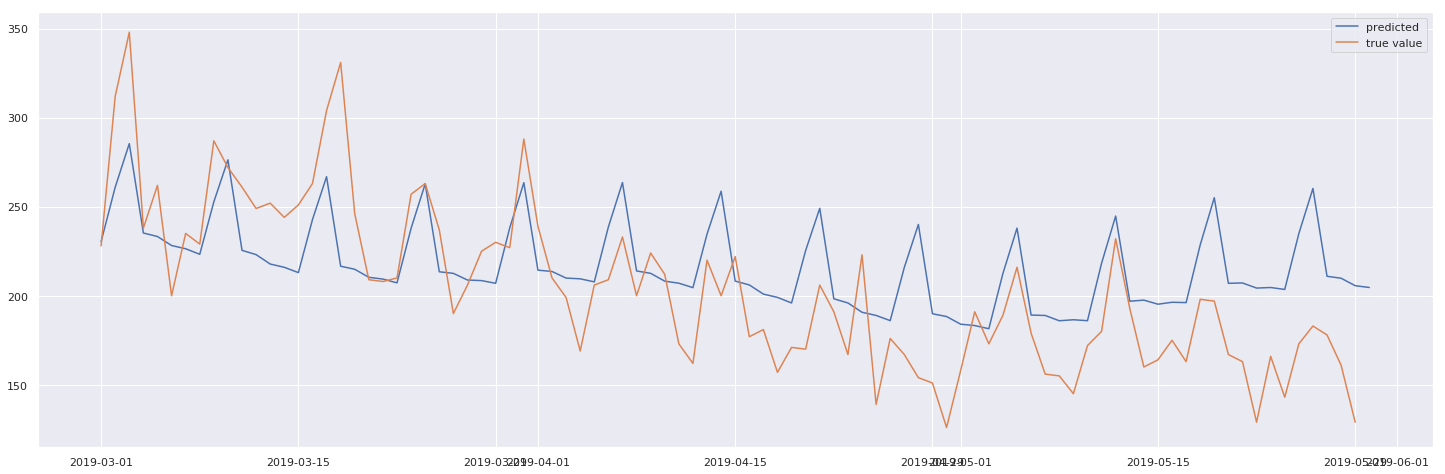

In [39]:
fig, ax = plt.subplots(figsize = (25, 8))
ax.plot(y_pred.ds, y_pred.yhat.values, label = 'predicted')
ax.plot(test_df.transaction_date, test_df.daily_quantity.values, label = 'true value')
plt.legend()
plt.show();

In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [41]:
mape(test_df.daily_quantity.values, y_pred[y_pred.ds.isin(test_df.transaction_date)].yhat.values)

0.161104716659582

### Grouping data by month

In [42]:
train_df_month = train_df.groupby([pd.Grouper(key='ds', freq='M')])['y'].sum().reset_index().sort_values('ds')

In [43]:
train_df_month.head()

,ds,y
0,2017-01-31,2453.0
1,2017-02-28,4540.0
2,2017-03-31,4836.0
3,2017-04-30,3744.0
4,2017-05-31,3622.0


In [44]:
m_model = Prophet()
m_model.fit(train_df_month)

/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.


In [45]:
future = m_model.make_future_dataframe(periods = 3, freq='M', include_history=False)

In [46]:
future.head()

,ds
0,2019-03-31
1,2019-04-30
2,2019-05-31


In [47]:
future.tail()

,ds
0,2019-03-31
1,2019-04-30
2,2019-05-31


In [48]:
forecast = model.predict(future)

In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2019-03-31,263.494210,226.073981,299.564217
1,2019-04-30,188.332774,151.607472,224.346719
2,2019-05-31,202.253178,166.097519,238.073057


### Forecasting for single product

In [50]:
df = transactions_df.select('transaction_date', 'quantity') \
.filter(transactions_df.sku_id == 1701820) \
.groupby('transaction_date') \
.agg(F.sum('quantity').alias('daily_quantity')) \
.orderBy('transaction_date').toPandas()

In [51]:
df.head()

,transaction_date,daily_quantity
0,2017-06-10,3.0000
1,2017-06-11,2.0000
2,2017-06-12,2.0000
3,2017-06-13,3.0000
4,2017-06-15,3.0000


In [52]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df.daily_quantity = pd.to_numeric(df.daily_quantity)

In [53]:
df.columns = ['ds', 'y']

In [54]:
month_df = df[df.ds <= '2019-04-30'].groupby([pd.Grouper(key='ds', freq='M')])['y'].sum().reset_index().sort_values('ds')

In [55]:
month_df.tail()

,ds,y
18,2018-12-31,98.0
19,2019-01-31,57.0
20,2019-02-28,47.0
21,2019-03-31,115.0
22,2019-04-30,57.0


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.0.
/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seas

True value: 57.0 Predict: [106.]


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.


True value: 115.0 Predict: [140.]


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.0.


True value: 47.0 Predict: [155.]
True value: 57.0 Predict: [189.]
1.4226755603161467


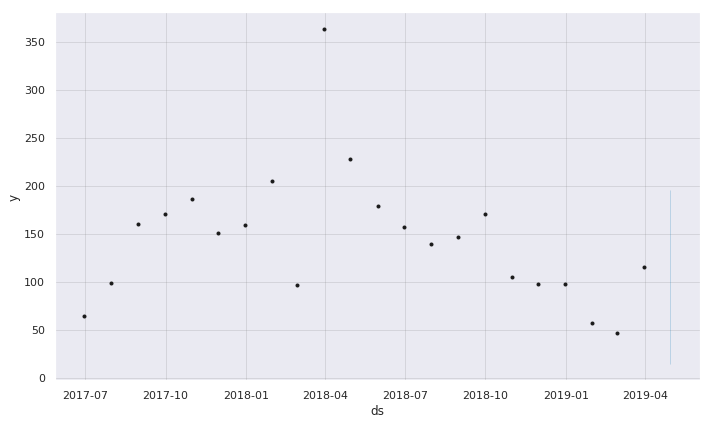

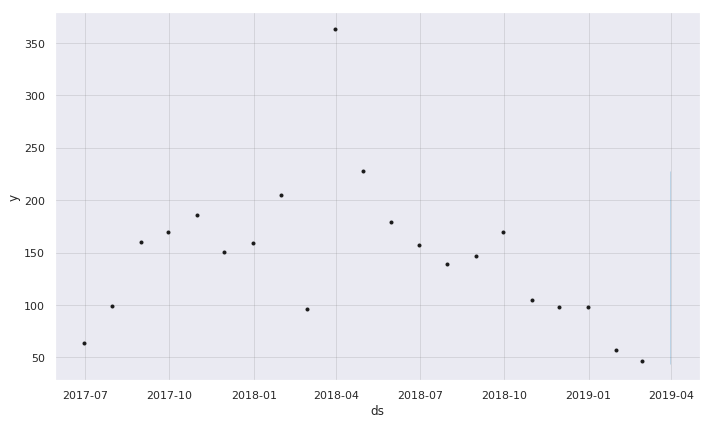

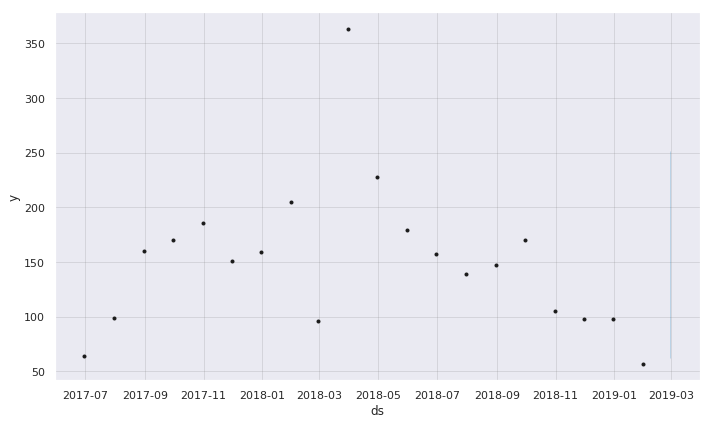

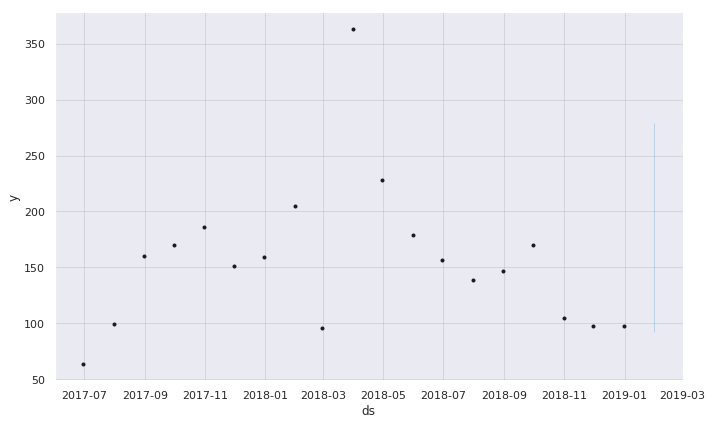

In [56]:
n_cv = 4
cv_mape = []
for i in range (n_cv):
    train_df = month_df.iloc[:-(i + 1)]
    test_df = month_df.iloc[-(i + 1)]
    model = Prophet()
    model.fit(train_df)

    future = model.make_future_dataframe(periods = 1, freq='M', include_history=False)
    forecast = model.predict(future)
    model.plot(forecast)
    print('True value:', test_df.y, 'Predict:', np.round(forecast.yhat.values))
    cv_mape.append(mape(test_df.y, np.round(forecast.yhat.values)))
print(np.mean(cv_mape))